<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Training a Multi-Object Tracking Model

## 00 Initialization

In [111]:
import sys

sys.path.append("../../")

import os
import os.path as osp
import time
from ipywidgets import Video
import matplotlib.pyplot as plt
import torch
import torchvision

from utils_cv.tracking.data import Urls
from utils_cv.tracking.dataset import TrackingDataset
from utils_cv.tracking.model import TrackingLearner, write_video

from utils_cv.common.data import data_path, download, unzip_url
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0a0+6b959ee
Torch is using GPU: Tesla K80


This shows your machine's GPUs (if it has any) and the computing device `torch/torchvision` is using.

In [112]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Next, set some model runtime parameters.

In [94]:
EPOCHS = 3
LEARNING_RATE = 0.0001
BATCH_SIZE = 1

SAVE_MODEL = True
FRAME_RATE = 30

CONF_THRES = 0.3
TRACK_BUFFER = 300
IM_SIZE = (1080, 1920)

TRAIN_DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
EVAL_DATA_PATH = unzip_url(Urls.carcans_annotations_path, exist_ok=True)

BASELINE_MODEL = "./models/all_dla34_new.pth"
FT_MODEL = "./models/model_30.pth"

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## 01 Finetune a Pretrained Model

Initialize the training dataset.

In [36]:
data_train = TrackingDataset(
    TRAIN_DATA_PATH,
    batch_size=BATCH_SIZE
)

dataset summary
OrderedDict([('default', 4.0)])
total # identities: 5
start index
OrderedDict([('default', 0)])


Initialize and load the model. We use the baseline FairMOT model, which can be downloaded [here](https://drive.google.com/file/d/1udpOPum8fJdoEQm6n0jsIgMMViOMFinu/view).

In [50]:
tracker = TrackingLearner(data_train, "./models/fairmot_ft.pth")
print(f"Model: {type(tracker.model)}")

Model: <class 'utils_cv.tracking.references.fairmot.models.networks.pose_dla_dcn.DLASeg'>


In [11]:
# Try 1
tracker.fit(num_epochs=EPOCHS, lr=LEARNING_RATE) #, resume=True)

Loading /data/home/maidapmot/blob_karineMOT/computervision-recipes/scenarios/tracking/models/all_dla34.pth
loaded /data/home/maidapmot/blob_karineMOT/computervision-recipes/scenarios/tracking/models/all_dla34.pth, epoch 10
=====  Epoch: 1/1  =====


KeyboardInterrupt: 

In [18]:
# Try 2
tracker.fit(num_epochs=EPOCHS, lr=LEARNING_RATE) #, resume=True) #start: 1:35pm

Loading /data/home/maidapmot/blob_karineMOT/computervision-recipes/scenarios/tracking/models/all_dla34.pth
loaded /data/home/maidapmot/blob_karineMOT/computervision-recipes/scenarios/tracking/models/all_dla34.pth, epoch 10
=====  Epoch: 1/3  =====
loss: 5.688030280172825
hm_loss: 0.9675696090926067
wh_loss: 3.713577752467245
off_loss: 0.225477239000611
id_loss: 1.5140858255326748
time: 2.1166666666666667
=====  Epoch: 2/3  =====
loss: 2.5902755483984947
hm_loss: 0.25830168069296633
wh_loss: 1.9550778358243406
off_loss: 0.205941129301209
id_loss: 1.3593879155814648
time: 2.1166666666666667
=====  Epoch: 3/3  =====
loss: 1.956469627097249
hm_loss: 0.16418991913451464
wh_loss: 1.6900474766734987
off_loss: 0.20701852095953654
id_loss: 1.1818380779586732
time: 2.1333333333333333
Model saved to ./models/fairmot_ft.pth


In [106]:
# Try 3
tracker.fit(num_epochs=EPOCHS, lr=LEARNING_RATE) #, resume=True) #start: 5:16pm

Loading /data/home/maidapmot/blob_karineMOT/computervision-recipes/scenarios/tracking/models/all_dla34.pth
loaded /data/home/maidapmot/blob_karineMOT/computervision-recipes/scenarios/tracking/models/all_dla34.pth, epoch 10
=====  Epoch: 1/3  =====
loss: 3.927435789257288
hm_loss: 0.5748318611840659
wh_loss: 2.5956204952672124
off_loss: 0.21613109100144356
id_loss: 1.4255490968935192
time: 4.366666666666666
=====  Epoch: 2/3  =====
loss: 1.7961845491081476
hm_loss: 0.1526481390205845
wh_loss: 1.683026997721754
off_loss: 0.20444884554308373
id_loss: 1.1026265325490385
time: 4.383333333333334
=====  Epoch: 3/3  =====
loss: 1.2963138888590038
hm_loss: 0.08059978576193316
wh_loss: 1.6261645593913272
off_loss: 0.19868546949874144
id_loss: 0.9386074647773057
time: 4.383333333333334
Model saved to ./models/fairmot_ft.pth


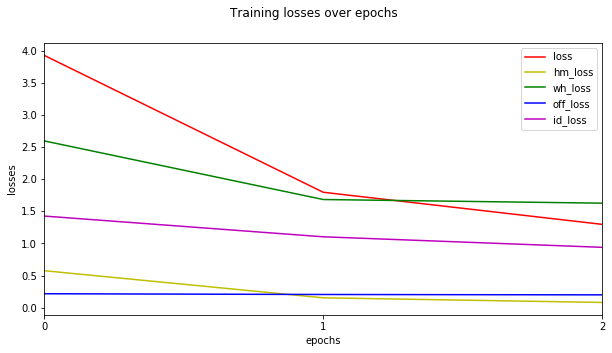

In [109]:
tracker.plot_training_losses()

In [20]:
if SAVE_MODEL:
    tracker.save(f"./models/model_{EPOCHS:02d}.pth")

Model saved to ./models/model_03.pth


## 02 Evaluate

Note that `EVAL_DATA_PATH` follows the FairMOT input format.

In [121]:
eval_results = tracker.predict(
    EVAL_DATA_PATH,
    conf_thres=CONF_THRES,
    track_buffer=TRACK_BUFFER,
    im_size=IM_SIZE,
    frame_rate=FRAME_RATE
)

Creating model...
loaded ./models/fairmot_ft.pth, epoch 3


In [124]:
eval_metrics = tracker.evaluate(eval_results, EVAL_DATA_PATH) 

            IDF1   IDP   IDR  Rcll  Prcn GT MT PT ML FP FN IDs  FM   MOTA  MOTP IDt IDa IDm
single_vid 33.6% 30.7% 36.5% 34.9% 29.7%  2  0  2  0 52 41   0  10 -47.6% 0.395   0   0   0
OVERALL    33.6% 30.7% 36.5% 34.9% 29.7%  2  0  2  0 52 41   0  10 -47.6% 0.395   0   0   0


## 03 Predict

In [99]:
input_video = download(
    Urls.carcans_video_path, osp.join(data_path(), "carcans.mp4")
)

In [100]:
test_results = tracker.predict(
    input_video,
    conf_thres=CONF_THRES,
    track_buffer=TRACK_BUFFER,
    im_size=IM_SIZE,
)

Creating model...
loaded ./models/fairmot_ft.pth, epoch 3
Lenth of the video: 251 frames


In [101]:
output_video = osp.join(data_path(), "carcans_output.mp4")

In [102]:
write_video(test_results, input_video, output_video)

Output saved to /data/home/maidapmot/blob_karineMOT/computervision-recipes/data/carcans_output.mp4.


In [103]:
Video.from_file(output_video)

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x011\x1almdat\x00\x00\x…